## Power generation Forecasting
by Hoang cute

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# Read the datasets
import glob
path = r'.\dataset - paper\weatherdata' # use your path
all_files = glob.glob(path + "/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0,encoding = 'unicode_escape')
    df = df.rename(columns={'ÁöÁ¡':'Point','ÀÏ½Ã':'datetime','±â¿Â(¡ÆC)':'Temperature (°C)','´©Àû°­¼ö·®(mm)':'Precipitation (mm)','Ç³Çâ(deg)':'Wind Direction (deg)'
    ,'Ç³¼Ó(m/s)':'Wind Speed ​​(m/s)','ÇöÁö±â¾Ð(hPa)':'Barometric Pressure (hPa)','ÇØ¸é±â¾Ð(hPa)':'Sea Level Pressure (hPa)','½Àµµ(%)':'Humidity (%)',
    'ÀÏ»ç(MJ/m^2)':'Insolation (MJ/m^2)','ÀÏÁ¶(Sec)':'Sunlight (Sec)'})
    df['datetime'] = pd.to_datetime(df['datetime'])
    li.append(df)

df_weather = pd.concat(li, axis=0, ignore_index=True)
df_weather = df_weather.drop_duplicates(keep=False)
df_weather = df_weather.drop(['Point'],axis=1).set_index('datetime')
df_weather.head()

,Temperature (°C),Precipitation (mm),Wind Direction (deg),Wind Speed ​​(m/s),Barometric Pressure (hPa),Sea Level Pressure (hPa),Humidity (%),Insolation (MJ/m^2),Sunlight (Sec)
datetime,,,,,,,,,
2021-01-01 00:01:00,-4.2,0.0,323.6,5.1,1020.5,1025.7,59.7,0.0,0.0
2021-01-01 00:02:00,-4.1,0.0,315.7,5.7,1020.5,1025.7,58.3,0.0,0.0
2021-01-01 00:03:00,-4.0,0.0,308.5,4.6,1020.5,1025.7,58.1,0.0,0.0
2021-01-01 00:04:00,-4.1,0.0,305.5,5.3,1020.6,1025.8,58.5,0.0,0.0
2021-01-01 00:05:00,-4.1,0.0,309.0,4.8,1020.6,1025.8,58.8,0.0,0.0


In [4]:
print(len(df_weather))

782361


In [5]:
davg_hourly = df_weather.resample('H').median()
davg_solar_last = df_weather[['Insolation (MJ/m^2)','Sunlight (Sec)']].resample('H').last()
davg_solar_first = df_weather[['Insolation (MJ/m^2)','Sunlight (Sec)']].resample('H').first()
davg_solar = davg_solar_last.subtract(davg_solar_first,fill_value=0).rename(columns={'Insolation (MJ/m^2)':'Insolation (MJ/m^2) per hour','Sunlight (Sec)':'Sunlight (Sec) per hour'})
davg_solar[davg_solar<0] = 0
fr_weather = pd.merge(davg_hourly,davg_solar,left_index=True,right_index=True).drop(['Insolation (MJ/m^2)','Sunlight (Sec)'],axis=1)
fr_weather = fr_weather.reset_index()
fr_weather = fr_weather[(fr_weather.datetime < '2022-01-01 00:00:00') | (fr_weather.datetime >= '2022-02-01 00:00:00')].set_index('datetime')

fr_weather.head()

,Temperature (°C),Precipitation (mm),Wind Direction (deg),Wind Speed ​​(m/s),Barometric Pressure (hPa),Sea Level Pressure (hPa),Humidity (%),Insolation (MJ/m^2) per hour,Sunlight (Sec) per hour
datetime,,,,,,,,,
2021-01-01 00:00:00,-4.3,0.0,317.30,4.70,1020.90,1026.10,57.00,0.0,0.0
2021-01-01 01:00:00,-4.8,0.0,329.20,3.60,1020.80,1026.00,57.05,0.0,0.0
2021-01-01 02:00:00,-5.2,0.0,335.50,3.15,1020.80,1026.00,59.35,0.0,0.0
2021-01-01 03:00:00,-5.1,0.0,330.95,4.05,1021.40,1026.60,60.45,0.0,0.0
2021-01-01 04:00:00,-4.8,0.0,324.65,4.05,1021.45,1026.65,59.30,0.0,0.0


In [6]:
print(len(davg_hourly))
print(len(davg_solar_last))
print(len(davg_solar_first))
print(len(fr_weather))


13104
13104
13104
12360


In [7]:
fr_weather.head()

,Temperature (°C),Precipitation (mm),Wind Direction (deg),Wind Speed ​​(m/s),Barometric Pressure (hPa),Sea Level Pressure (hPa),Humidity (%),Insolation (MJ/m^2) per hour,Sunlight (Sec) per hour
datetime,,,,,,,,,
2021-01-01 00:00:00,-4.3,0.0,317.30,4.70,1020.90,1026.10,57.00,0.0,0.0
2021-01-01 01:00:00,-4.8,0.0,329.20,3.60,1020.80,1026.00,57.05,0.0,0.0
2021-01-01 02:00:00,-5.2,0.0,335.50,3.15,1020.80,1026.00,59.35,0.0,0.0
2021-01-01 03:00:00,-5.1,0.0,330.95,4.05,1021.40,1026.60,60.45,0.0,0.0
2021-01-01 04:00:00,-4.8,0.0,324.65,4.05,1021.45,1026.65,59.30,0.0,0.0


In [8]:
fr_weather.to_csv('Gyeongjusi_hourly.csv')

In [9]:
# Read the datasets
import glob
path = r'.\dataset - paper\ensdata' # use your path
all_files = glob.glob(path + "/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df_energy = pd.concat(li, axis=0, ignore_index=True)
df_energy = df_energy[pd.to_numeric(df_energy['Hour'], errors='coerce').notnull()]
#df_energy = df_energy.drop_duplicates(keep=False)
df_energy['datetime'] = pd.to_datetime(df_energy['Date'] + ' ' + df_energy['Hour'] + ':00:00')
df_energy = df_energy.drop(['Date','Hour'],axis=1).set_index('datetime')
df_energy.head()

,P(kWh),h_max
datetime,,
2021-01-01 00:00:00,0,33391
2021-01-01 01:00:00,0,33391
2021-01-01 02:00:00,0,33391
2021-01-01 03:00:00,0,33391
2021-01-01 04:00:00,0,33391


In [10]:
print(len(df_energy))

12965


In [11]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

In [12]:
df_merge = pd.merge(
    fr_weather,
    df_energy,
    how="outer",
    on="datetime",
    sort=True
)
df_merge = df_convert_dtypes(df_merge, np.object, np.float64)
df_merge.head(30)

,Temperature (°C),Precipitation (mm),Wind Direction (deg),Wind Speed ​​(m/s),Barometric Pressure (hPa),Sea Level Pressure (hPa),Humidity (%),Insolation (MJ/m^2) per hour,Sunlight (Sec) per hour,P(kWh),h_max
datetime,,,,,,,,,,,
2021-01-01 00:00:00,-4.30,0.0,317.30,4.70,1020.90,1026.10,57.00,0.00,0.0,0.0,33391.0
2021-01-01 01:00:00,-4.80,0.0,329.20,3.60,1020.80,1026.00,57.05,0.00,0.0,0.0,33391.0
2021-01-01 02:00:00,-5.20,0.0,335.50,3.15,1020.80,1026.00,59.35,0.00,0.0,0.0,33391.0
2021-01-01 03:00:00,-5.10,0.0,330.95,4.05,1021.40,1026.60,60.45,0.00,0.0,0.0,33391.0
2021-01-01 04:00:00,-4.80,0.0,324.65,4.05,1021.45,1026.65,59.30,0.00,0.0,0.0,33391.0
2021-01-01 05:00:00,-4.80,0.0,334.55,4.90,1021.30,1026.50,57.15,0.00,0.0,0.0,33391.0
2021-01-01 06:00:00,-5.20,0.0,272.65,3.10,1021.80,1027.00,58.05,0.00,0.0,0.0,33391.0
2021-01-01 07:00:00,-9.00,0.0,177.20,2.95,1022.00,1027.30,79.55,0.02,0.0,0.0,33391.0
2021-01-01 08:00:00,-7.45,0.0,191.20,3.20,1022.70,1028.00,72.40,0.44,2376.0,4.0,33395.0


In [13]:
print(len(df_merge))

13104


In [14]:
df_merge.describe()

,Temperature (°C),Precipitation (mm),Wind Direction (deg),Wind Speed ​​(m/s),Barometric Pressure (hPa),Sea Level Pressure (hPa),Humidity (%),Insolation (MJ/m^2) per hour,Sunlight (Sec) per hour,P(kWh),h_max
count,12329.000000,12196.000000,12318.000000,12318.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12965.000000,12965.000000
mean,13.788284,1.332953,190.283228,2.594804,1011.578990,1016.386322,66.052685,0.649091,948.211192,17.161743,135344.318858
std,9.880354,5.585651,92.077341,1.637471,7.534894,7.698338,23.865162,0.955693,1446.187853,25.926816,67050.665757
min,-12.600000,0.000000,0.000000,0.000000,991.400000,995.900000,7.750000,0.000000,0.000000,0.000000,33391.000000
25%,6.300000,0.000000,145.612500,1.300000,1006.000000,1010.700000,46.900000,0.000000,0.000000,0.000000,75567.000000
50%,14.700000,0.000000,187.850000,2.200000,1011.800000,1016.600000,69.850000,0.030000,0.000000,1.000000,134570.000000
75%,21.750000,0.000000,271.662500,3.700000,1017.200000,1022.100000,88.150000,1.120000,2217.000000,28.000000,193268.000000
max,36.300000,89.300000,355.350000,11.250000,1031.900000,1037.100000,98.600000,4.250000,6192.000000,99.000000,259530.000000


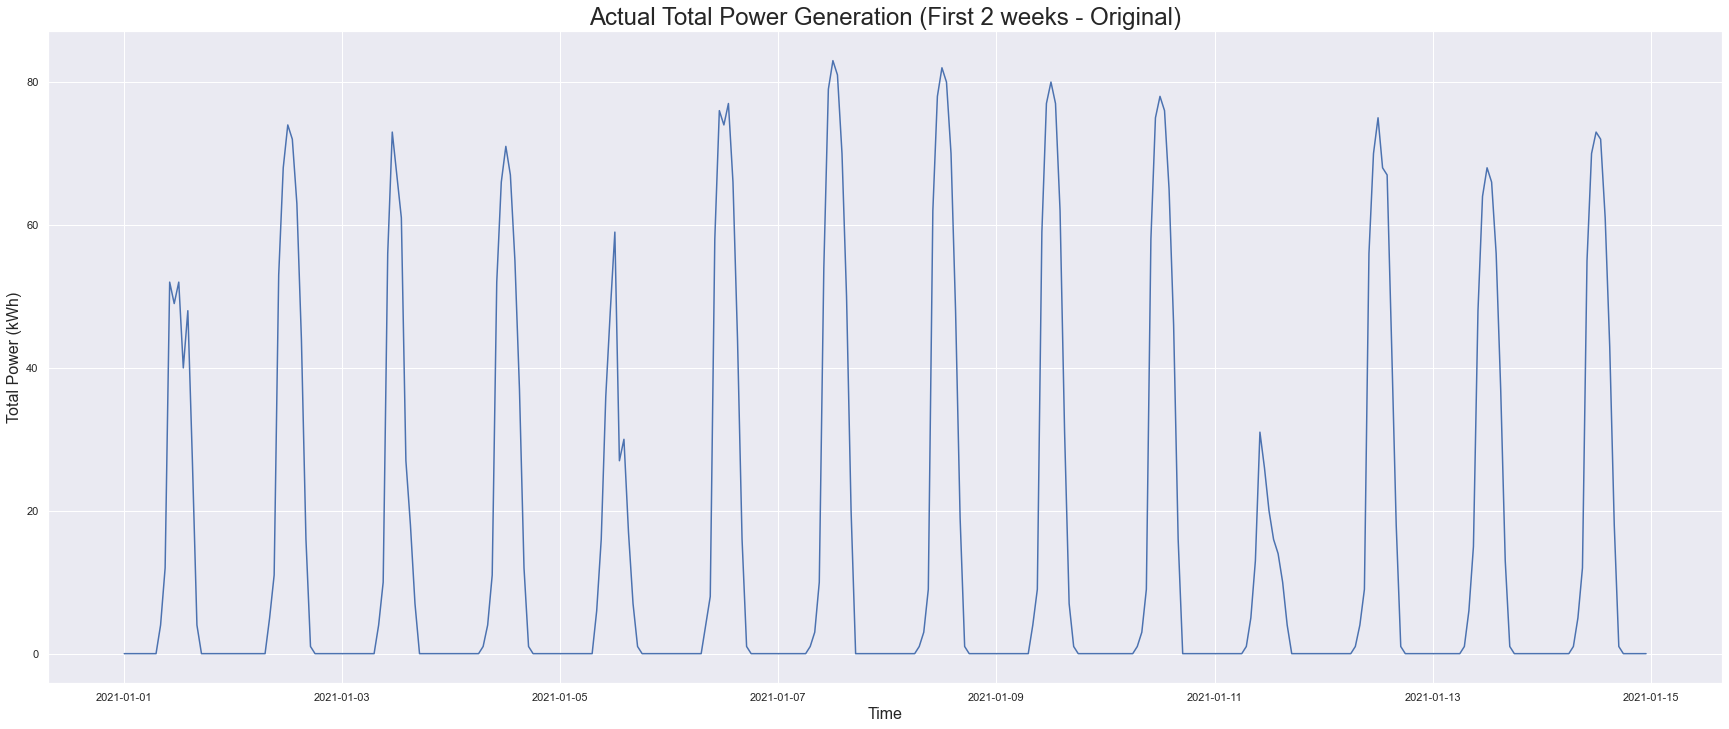

In [15]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax
    # Zoom into the plot of the hourly (actual) total load

ax = plot_series(df=df_merge, column='P(kWh)', ylabel='Total Power (kWh)',
                 title='Actual Total Power Generation (First 2 weeks - Original)', end=24*7*2)
plt.show()

In [16]:
# Display the rows with null values

df_merge[df_merge.isnull().any(axis=1)].tail()

,Temperature (°C),Precipitation (mm),Wind Direction (deg),Wind Speed ​​(m/s),Barometric Pressure (hPa),Sea Level Pressure (hPa),Humidity (%),Insolation (MJ/m^2) per hour,Sunlight (Sec) per hour,P(kWh),h_max
datetime,,,,,,,,,,,
2022-04-11 19:00:00,19.15,NaN,192.05,4.55,1007.0,1011.7,74.15,0.0,0.0,0.0,218922.0
2022-04-11 20:00:00,18.40,NaN,186.65,3.75,1007.8,1012.5,77.00,0.0,0.0,0.0,218922.0
2022-04-11 21:00:00,17.70,NaN,198.55,2.80,1008.3,1013.0,79.00,0.0,0.0,0.0,218922.0
2022-04-11 22:00:00,17.10,NaN,203.30,3.70,1008.2,1012.9,81.60,0.0,0.0,0.0,218922.0
2022-04-11 23:00:00,16.70,NaN,186.60,2.20,1008.4,1013.1,82.80,0.0,0.0,0.0,218922.0


In [17]:
# Fill null values using interpolation

df_merge.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [18]:
# Display the number of non-zero values in each column

print('Non-zero values in each column:\n', df_merge.astype(bool).sum(axis=0), sep='\n')

Non-zero values in each column:

Temperature (°C)                13081
Precipitation (mm)               2200
Wind Direction (deg)            13061
Wind Speed ​​(m/s)              13061
Barometric Pressure (hPa)       13104
Sea Level Pressure (hPa)        13104
Humidity (%)                    13104
Insolation (MJ/m^2) per hour     6606
Sunlight (Sec) per hour          4560
P(kWh)                           6601
h_max                           13104
dtype: int64


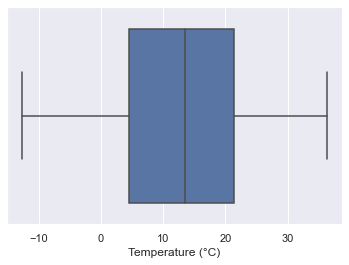

In [19]:
# Check for outliers in 'pressure' column

sns.boxplot(x=df_merge['Temperature (°C)'])
plt.show()

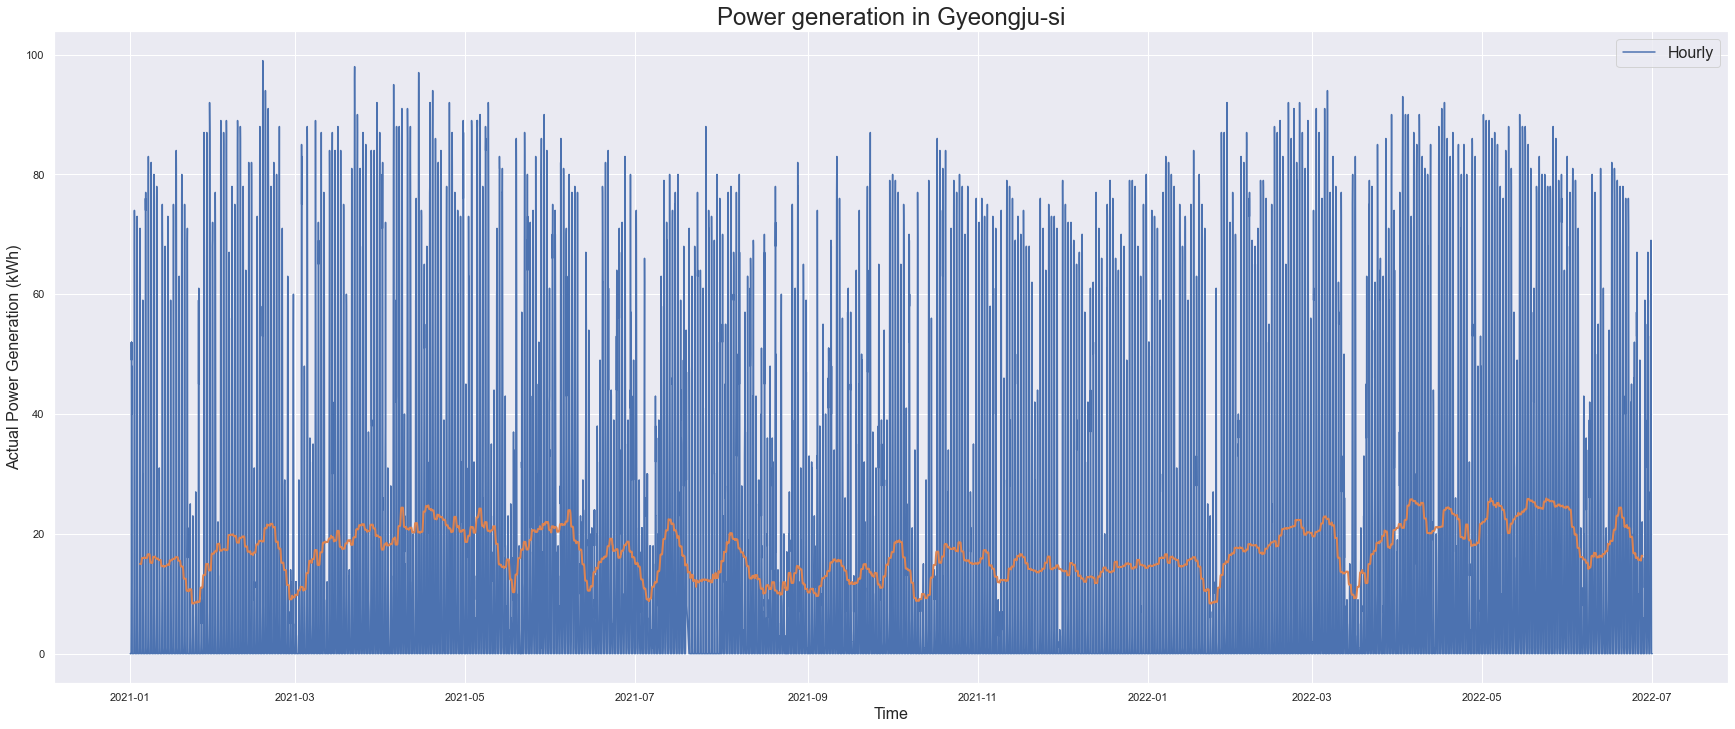

In [20]:
# Plot the 'rain_1h' for Bilbao
rolling = df_merge['P(kWh)'].rolling(24*7, center=True).mean()

ax = plot_series(df_merge, 'P(kWh)', 
                 label='Hourly', ylabel='Actual Power Generation (kWh)',
                 title='Power generation in Gyeongju-si')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')

plt.show()

## <a id='ref14'>2.3. Autocorrelation, partial autocorrelation and cross-correlation</a> 

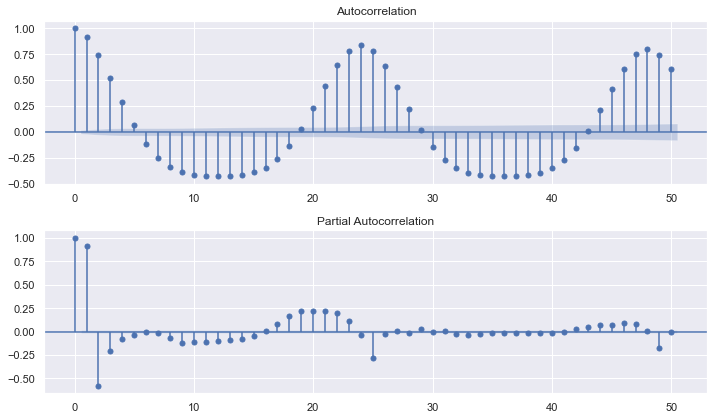

In [21]:
# Plot autocorrelation and partial autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_merge['P(kWh)'], lags=50, ax=ax1)
plot_pacf(df_merge['P(kWh)'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

In [22]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13104 entries, 2021-01-01 00:00:00 to 2022-06-30 23:00:00
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Temperature (°C)              13104 non-null  float64
 1   Precipitation (mm)            13104 non-null  float64
 2   Wind Direction (deg)          13104 non-null  float64
 3   Wind Speed ​​(m/s)            13104 non-null  float64
 4   Barometric Pressure (hPa)     13104 non-null  float64
 5   Sea Level Pressure (hPa)      13104 non-null  float64
 6   Humidity (%)                  13104 non-null  float64
 7   Insolation (MJ/m^2) per hour  13104 non-null  float64
 8   Sunlight (Sec) per hour       13104 non-null  float64
 9   P(kWh)                        13104 non-null  float64
 10  h_max                         13104 non-null  float64
dtypes: float64(11)
memory usage: 1.2 MB


In [23]:
# Find the correlations between the electricity price and the rest of the features

correlations = df_merge.corr(method='pearson')
print(correlations.columns)
print(correlations['P(kWh)'].sort_values(ascending=False).to_string())

Index(['Temperature (°C)', 'Precipitation (mm)', 'Wind Direction (deg)',
       'Wind Speed ​​(m/s)', 'Barometric Pressure (hPa)',
       'Sea Level Pressure (hPa)', 'Humidity (%)',
       'Insolation (MJ/m^2) per hour', 'Sunlight (Sec) per hour', 'P(kWh)',
       'h_max'],
      dtype='object')
P(kWh)                          1.000000
Insolation (MJ/m^2) per hour    0.910324
Sunlight (Sec) per hour         0.780925
Wind Speed ​​(m/s)              0.289267
Temperature (°C)                0.250507
Wind Direction (deg)            0.079818
h_max                           0.045914
Barometric Pressure (hPa)      -0.020188
Sea Level Pressure (hPa)       -0.025940
Precipitation (mm)             -0.088151
Humidity (%)                   -0.514858


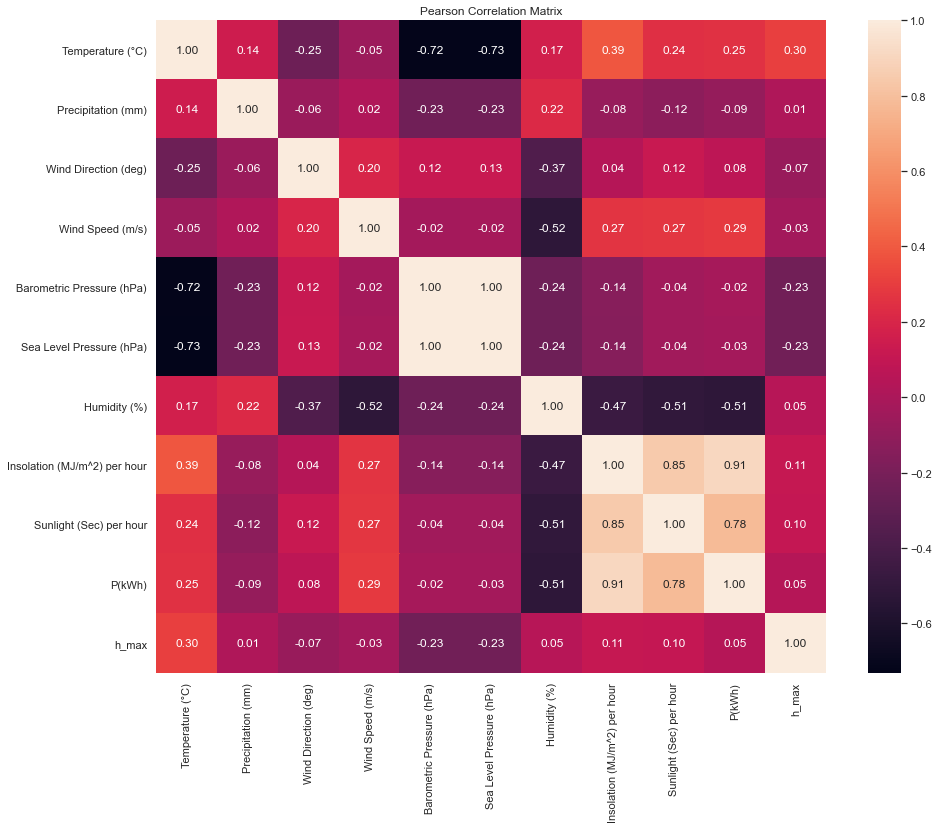

In [24]:
# Plot Pearson correlation matrix

correlations = df_merge.corr(method='pearson')
fig = plt.figure(figsize=(15, 12))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [25]:
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

Barometric Pressure (hPa)     Sea Level Pressure (hPa)        0.999842
Sea Level Pressure (hPa)      Barometric Pressure (hPa)       0.999842
Insolation (MJ/m^2) per hour  Sunlight (Sec) per hour         0.845905
                              P(kWh)                          0.910324
Sunlight (Sec) per hour       Insolation (MJ/m^2) per hour    0.845905
                              P(kWh)                          0.780925
P(kWh)                        Insolation (MJ/m^2) per hour    0.910324
                              Sunlight (Sec) per hour         0.780925


## <a id='ref17'>Feature selection</a> 

In [26]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [27]:
train_end_idx = 8760
cv_end_idx = 10176
test_end_idx = 12000

In [28]:
df_final  = df_merge.copy()
# Wind Direction (deg)            0.086512
# h_max                           0.035325
# Barometric Pressure (hPa)      -0.010425
# Sea Level Pressure (hPa)       -0.016479
# Precipitation (mm)             -0.092167
# Humidity (%)                   -0.548498
X = df_final[df_final.columns.drop(['P(kWh)','Wind Direction (deg)','h_max','Barometric Pressure (hPa)','Sea Level Pressure (hPa)','Precipitation (mm)'])].values
y = df_final['P(kWh)'].values

y = y.reshape(-1, 1)

In [29]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [30]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [31]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [32]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit(X_norm[:train_end_idx])

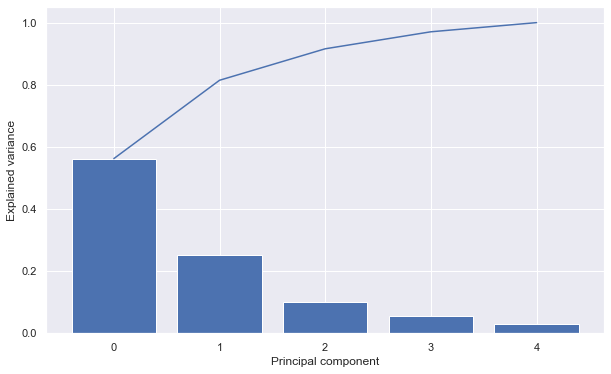

In [33]:
num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

In [34]:
pca = PCA(n_components=0.95)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)

In [35]:
X_pca.shape

(13104, 4)

In [36]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 24*7
future_target = 24

In [37]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=False)

In [38]:
print(y_train.shape)
print(X_train.shape)

(8592, 24)
(8592, 168, 5)


In [39]:
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=False)

In [40]:
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=False)

In [41]:
batch_size = 32
buffer_size = 1000

In [42]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [43]:
# Define some common parameters

input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [44]:
#y_test = y_test.reshape(-1, 1)
y_test = y_test.reshape(-1, future_target)
y_test_inv = scaler_y.inverse_transform(y_test)

In [45]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

## 1. XG Boost

In [46]:
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

In [47]:
X_train_xgb.shape

(8592, 840)

## 2. LSTM

In [48]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(future_target)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [49]:
history = multivariate_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120
269/269 [==============================] - 24s 45ms/step - loss: 0.1484 - root_mean_squared_error: 0.3392 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1296: 1s - loss: 0.1715 - roo
Epoch 2/120
269/269 [==============================] - 11s 39ms/step - loss: 0.0205 - root_mean_squared_error: 0.1430 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1179root_mean
Epoch 3/120
269/269 [==============================] - 10s 38ms/step - loss: 0.0193 - root_mean_squared_error: 0.1390 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1169 loss: 0.0192 - root_mean_squared_error: 0.1 - ETA: 6s  - ETA: 2s - loss: 0.0
Epoch 4/120
269/269 [==============================] - 10s 38ms/step - loss: 0.0186 - root_mean_squared_error: 0.1363 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1249
Epoch 5/120
269/269 [==============================] - 11s 41ms/step - loss: 0.0179 - root_mean_squared_error: 0.1338 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1188.0179 - root_me

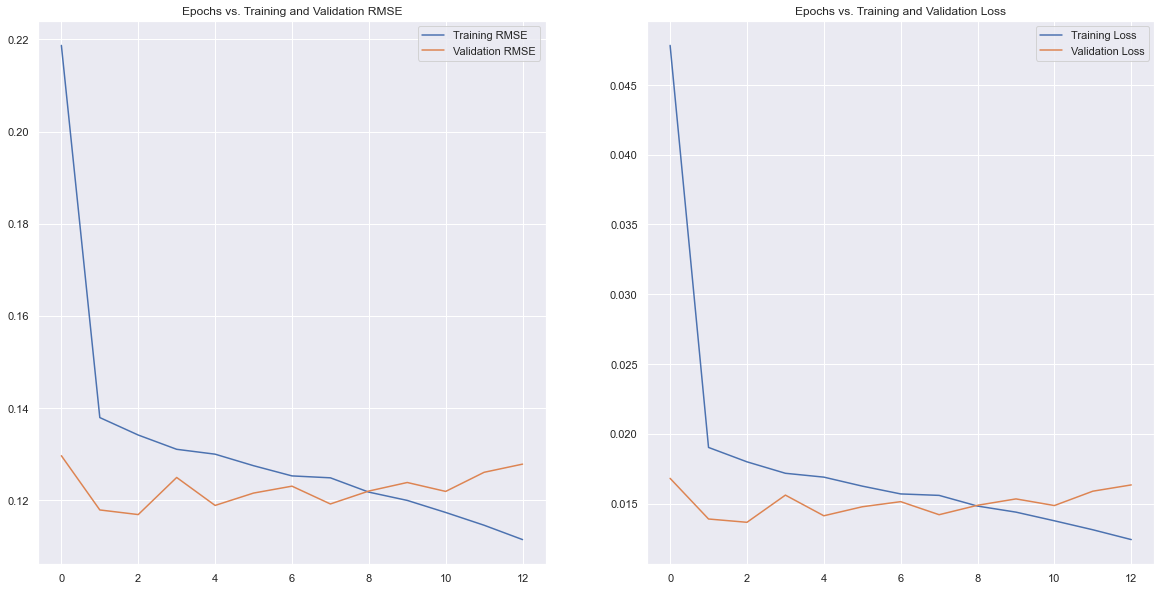

In [50]:
plot_model_rmse_and_loss(history)

In [51]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of hour-ahead power generation LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))

RMSE of hour-ahead power generation LSTM forecast: 16.107


In [52]:
df_final  = df_merge.copy()
# Wind Direction (deg)            0.086512
# h_max                           0.035325
# Barometric Pressure (hPa)      -0.010425
# Sea Level Pressure (hPa)       -0.016479
# Precipitation (mm)             -0.092167
# Humidity (%)                   -0.548498
X = df_final[df_final.columns.drop(['P(kWh)','Wind Direction (deg)','h_max','Barometric Pressure (hPa)','Sea Level Pressure (hPa)','Precipitation (mm)'])].values
y = df_final['P(kWh)'].values

y = y.reshape(-1, 1)

## Stacked LSTM

In [53]:
tf.keras.backend.clear_session()

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape, 
         return_sequences=True),
    LSTM(150, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(future_target)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_stacked_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=3e-3, amsgrad=True)

multivariate_stacked_lstm.compile(loss=loss,
                                  optimizer=optimizer,
                                  metrics=metric)

In [54]:
history = multivariate_stacked_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120
269/269 [==============================] - 35s 88ms/step - loss: 0.1031 - root_mean_squared_error: 0.2357 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1400
Epoch 2/120
269/269 [==============================] - 25s 91ms/step - loss: 0.0192 - root_mean_squared_error: 0.1385 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1386
Epoch 3/120
269/269 [==============================] - 23s 86ms/step - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1225
Epoch 4/120
269/269 [==============================] - 22s 82ms/step - loss: 0.0165 - root_mean_squared_error: 0.1283 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1221
Epoch 5/120
269/269 [==============================] - 21s 77ms/step - loss: 0.0154 - root_mean_squared_error: 0.1242 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1438
Epoch 6/120
269/269 [==============================] - 21s 78ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218 - val_l

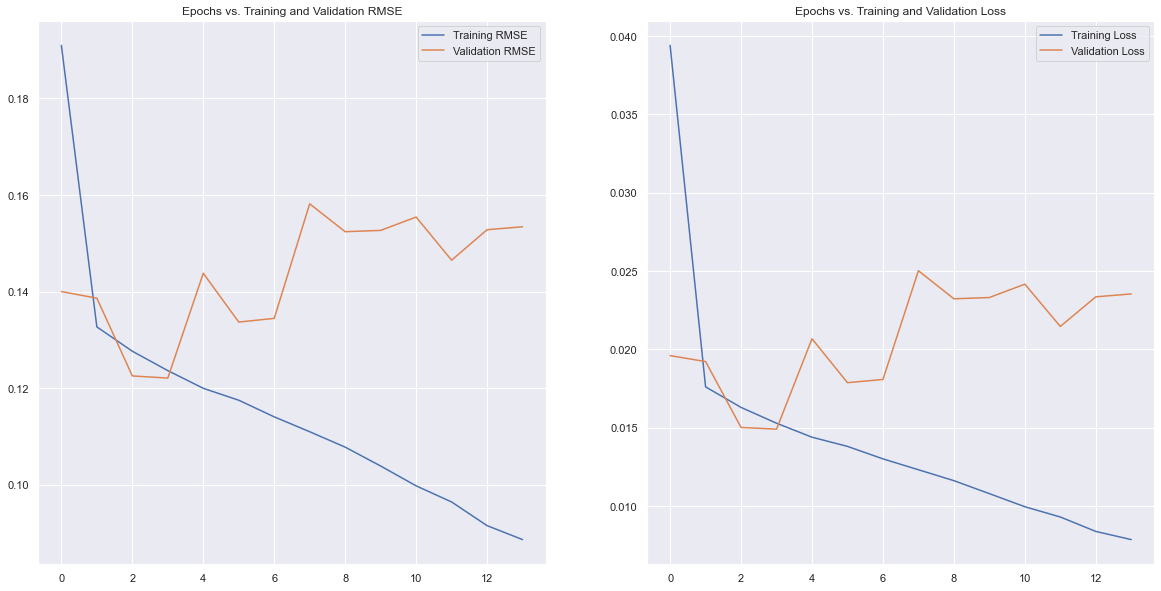

In [55]:
plot_model_rmse_and_loss(history)

In [56]:
multivariate_stacked_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.h5')

forecast = multivariate_stacked_lstm.predict(X_test)
multivariate_stacked_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_stacked_lstm = sqrt(mean_squared_error(y_test_inv, 
                                                 multivariate_stacked_lstm_forecast))
print('RMSE of hour-ahead power generation multivariate Stacked LSTM forecast: {}'
      .format(round(rmse_mult_stacked_lstm, 3)))


RMSE of hour-ahead power generation multivariate Stacked LSTM forecast: 15.684


## 1D CNN

In [57]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(future_target)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [58]:
history = multivariate_cnn.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/120
269/269 [==============================] - 7s 9ms/step - loss: 0.0826 - root_mean_squared_error: 0.2272 - val_loss: 0.0318 - val_root_mean_squared_error: 0.1784
Epoch 2/120
269/269 [==============================] - 2s 8ms/step - loss: 0.0209 - root_mean_squared_error: 0.1446 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1553
Epoch 3/120
269/269 [==============================] - 2s 8ms/step - loss: 0.0172 - root_mean_squared_error: 0.1310 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1472
Epoch 4/120
269/269 [==============================] - 2s 8ms/step - loss: 0.0159 - root_mean_squared_error: 0.1261 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1530
Epoch 5/120
269/269 [==============================] - 2s 7ms/step - loss: 0.0155 - root_mean_squared_error: 0.1244 - val_loss: 0.0252 - val_root_mean_squared_error: 0.1587
Epoch 6/120
269/269 [==============================] - 2s 7ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218 - val_loss: 0.0249 

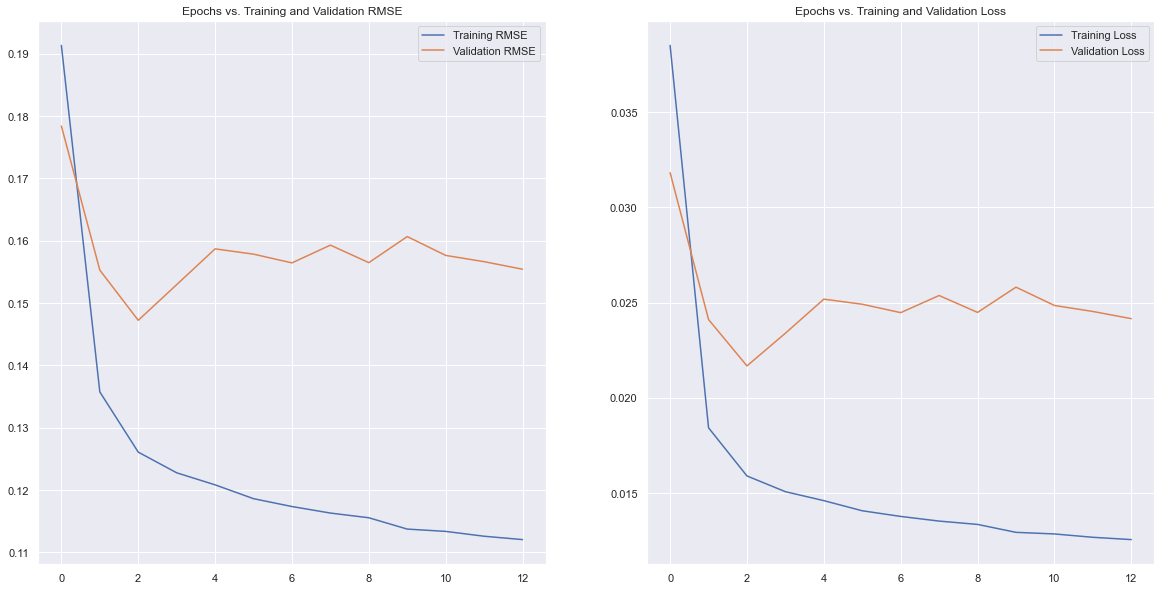

In [59]:
plot_model_rmse_and_loss(history)

In [60]:
multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast = multivariate_cnn.predict(X_test)
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_cnn_forecast))
print('RMSE of hour-ahead power generation multivariate CNN forecast: {}'
      .format(round(rmse_mult_cnn, 3)))

RMSE of hour-ahead power generation multivariate CNN forecast: 15.584


## CNN-LSTM

In [61]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    LSTM(100, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(future_target)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=4e-3, amsgrad=True)

multivariate_cnn_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)


In [62]:
history = multivariate_cnn_lstm.fit(train, epochs=120,
                                    validation_data=validation,
                                    callbacks=[early_stopping, 
                                               model_checkpoint])

Epoch 1/120
269/269 [==============================] - 16s 37ms/step - loss: 0.0715 - root_mean_squared_error: 0.2257 - val_loss: 0.0297 - val_root_mean_squared_error: 0.1723
Epoch 2/120
269/269 [==============================] - 9s 32ms/step - loss: 0.0258 - root_mean_squared_error: 0.1606 - val_loss: 0.0260 - val_root_mean_squared_error: 0.16128 
Epoch 3/120
269/269 [==============================] - 8s 31ms/step - loss: 0.0233 - root_mean_squared_error: 0.1527 - val_loss: 0.0251 - val_root_mean_squared_error: 0.1585
Epoch 4/120
269/269 [==============================] - 8s 31ms/step - loss: 0.0218 - root_mean_squared_error: 0.1475 - val_loss: 0.0191 - val_root_mean_squared_error: 0.1381
Epoch 5/120
269/269 [==============================] - 9s 32ms/step - loss: 0.0166 - root_mean_squared_error: 0.1288 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1376
Epoch 6/120
269/269 [==============================] - 8s 31ms/step - loss: 0.0154 - root_mean_squared_error: 0.1239 - val_loss

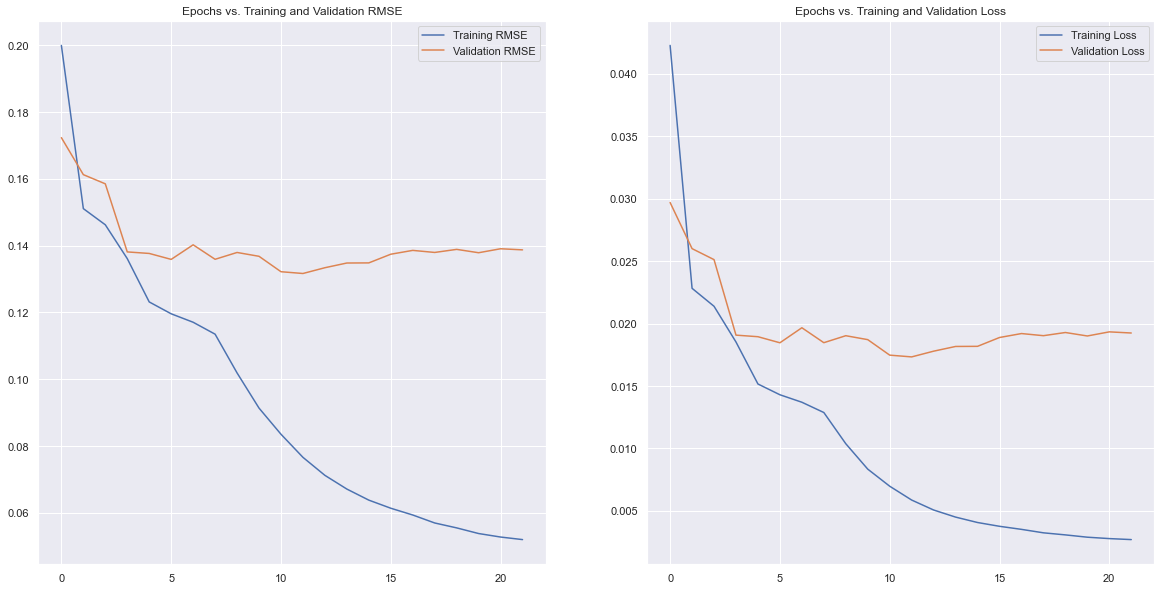

In [63]:
plot_model_rmse_and_loss(history)

In [64]:
multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.h5')

forecast = multivariate_cnn_lstm.predict(X_test)
multivariate_cnn_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn_lstm = sqrt(mean_squared_error(y_test_inv, 
                                             multivariate_cnn_lstm_forecast))
print('RMSE of hour-ahead power generation multivariate CNN-LSTM forecast: {}'
      .format(round(rmse_mult_cnn_lstm, 3)))

RMSE of hour-ahead power generation multivariate CNN-`LSTM forecast: 17.239


In [65]:
X_test.shape

(1656, 168, 5)

## MLP

In [66]:
tf.keras.backend.clear_session()

multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, activation='relu'),
                    input_shape=input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(100, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(future_target)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_mlp.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=2e-3, amsgrad=True)

multivariate_mlp.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [67]:
history = multivariate_mlp.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/120
269/269 [==============================] - 5s 11ms/step - loss: 0.0279 - root_mean_squared_error: 0.1521 - val_loss: 0.0164 - val_root_mean_squared_error: 0.1282
Epoch 2/120
269/269 [==============================] - 3s 10ms/step - loss: 0.0147 - root_mean_squared_error: 0.1213 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1264
Epoch 3/120
269/269 [==============================] - 2s 9ms/step - loss: 0.0123 - root_mean_squared_error: 0.1109 - val_loss: 0.0193 - val_root_mean_squared_error: 0.1390
Epoch 4/120
269/269 [==============================] - 2s 9ms/step - loss: 0.0107 - root_mean_squared_error: 0.1036 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1189
Epoch 5/120
269/269 [==============================] - 2s 9ms/step - loss: 0.0093 - root_mean_squared_error: 0.0964 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1228
Epoch 6/120
269/269 [==============================] - 3s 10ms/step - loss: 0.0082 - root_mean_squared_error: 0.0905 - val_loss: 0.01

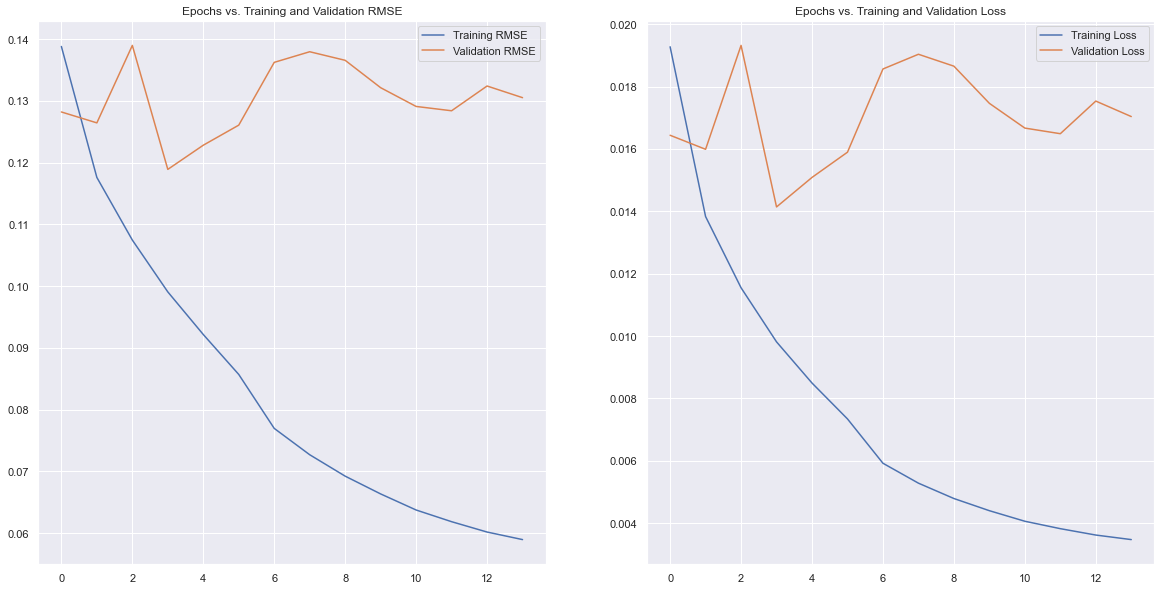

In [68]:
plot_model_rmse_and_loss(history)

In [69]:
multivariate_mlp = tf.keras.models.load_model('multivariate_mlp.h5')

forecast = multivariate_mlp.predict(X_test)
multivariate_mlp_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_mlp = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_mlp_forecast))
print('RMSE of hour-ahead power generation multivariate MLP forecast: {}'
      .format(round(rmse_mult_mlp, 3)))

RMSE of hour-ahead power generation multivariate MLP forecast: 15.558


## Autoencoder

In [70]:
tf.keras.backend.clear_session()

encoder_decoder = tf.keras.models.Sequential([
    LSTM(50, activation='relu', input_shape=input_shape),
    RepeatVector(past_history),
    LSTM(50, activation='relu', return_sequences=True),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(40, activation='relu'),
    Dense(future_target)
])



model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'encoder_decoder.h5', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)

encoder_decoder.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=metric)

In [71]:
history = encoder_decoder.fit(train, epochs=50,
                              validation_data=validation,
                              callbacks=[early_stopping, 
                                         model_checkpoint])

Epoch 1/50
269/269 [==============================] - 329s 1s/step - loss: 0.0454 - root_mean_squared_error: 0.1838 - val_loss: 0.0177 - val_root_mean_squared_error: 0.1331
Epoch 2/50
269/269 [==============================] - 314s 1s/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1194
Epoch 3/50
269/269 [==============================] - 326s 1s/step - loss: 0.0158 - root_mean_squared_error: 0.1255 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1172
Epoch 4/50
269/269 [==============================] - 326s 1s/step - loss: 0.0152 - root_mean_squared_error: 0.1233 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1113
Epoch 5/50
269/269 [==============================] - 432s 2s/step - loss: 0.0149 - root_mean_squared_error: 0.1221 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1115
Epoch 6/50
269/269 [==============================] - 308s 1s/step - loss: 0.0145 - root_mean_squared_error: 0.1201 - val_loss: 0.0124 

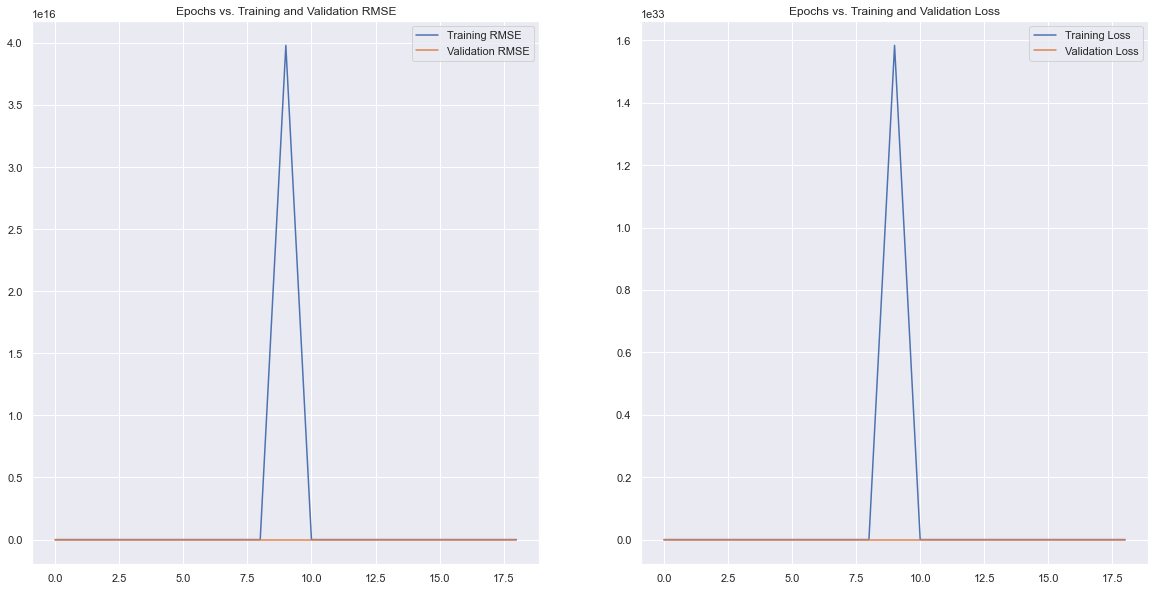

In [72]:
plot_model_rmse_and_loss(history)

In [73]:
encoder_decoder = tf.keras.models.load_model('encoder_decoder.h5')

forecast = encoder_decoder.predict(X_test)
encoder_decoder_forecast = scaler_y.inverse_transform(forecast)

rmse_encoder_decoder = sqrt(mean_squared_error(y_test_inv, 
                                               encoder_decoder_forecast))
print('RMSE of hour-ahead power generation Encoder-Decoder forecast: {}'
      .format(round(rmse_encoder_decoder, 3)))

RMSE of hour-ahead power generation Encoder-Decoder forecast: 13.46


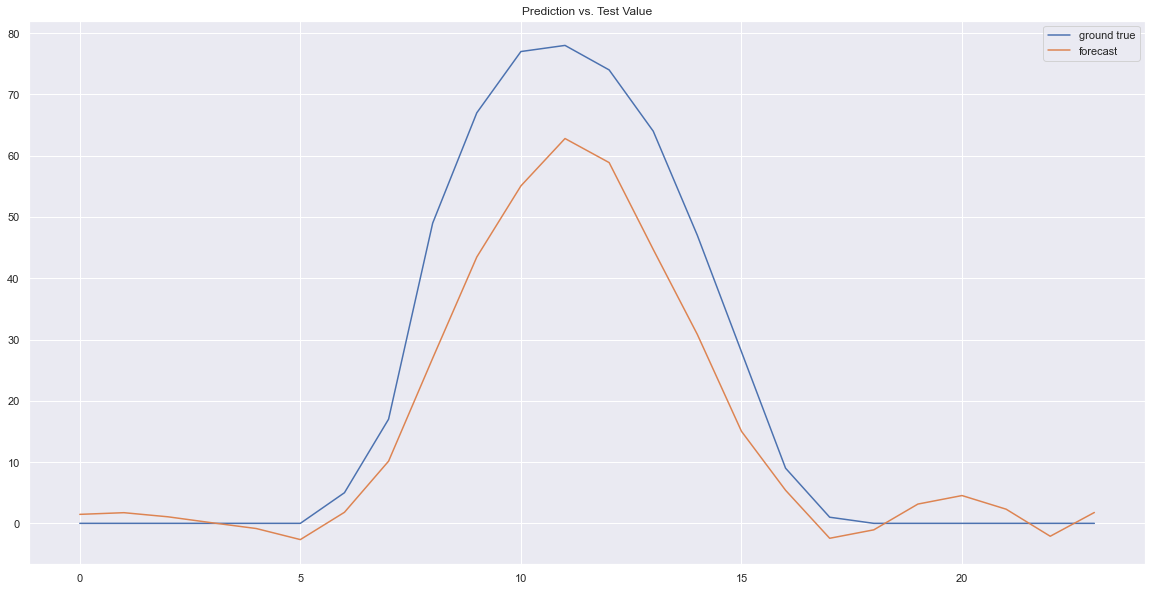

In [74]:
plt.figure(figsize=(20,10))
plt.plot(y_test_inv[25],label='ground true')
plt.plot(lstm_forecast[25],label='forecast')
plt.title('Prediction vs. Test Value')
plt.legend()